In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
import json
import matplotlib.pyplot as plt


In [2]:
# Load the dataset from JSON file
with open("./dataset.JSON", 'r', encoding='utf-8') as file:
    data = json.load(file)


In [3]:
# Preprocessing the Data
user_ids = []
item_titles = []
ratings = []

# Convert userID and book titles into numeric form using LabelEncoder
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Prepare the data
for entry in data:
    user_id = entry["userID"]
    for recommendation in entry["reccomendation"]:
        item_title = recommendation["title"]
        user_ids.append(user_id)
        item_titles.append(item_title)
        ratings.append(np.random.randint(1, 6))  # Assign random ratings for demonstration purposes

user_ids = user_encoder.fit_transform(user_ids)
item_titles = item_encoder.fit_transform(item_titles)


In [4]:
# Create the DataFrame
df = pd.DataFrame({
    'userID': user_ids,
    'itemID': item_titles,
    'rating': ratings
})

# Split data into train and test sets
X = df[['userID', 'itemID']]
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Menampilkan jumlah data pelatihan dan pengujian untuk memastikan semuanya benar
print(f"Jumlah data pelatihan: {X_train.shape[0]} data")
print(f"Jumlah data pengujian: {X_test.shape[0]} data")


Jumlah data pelatihan: 20 data
Jumlah data pengujian: 6 data


In [5]:
# Define Model for Neural Collaborative Filtering (NCF)
embedding_size = 50

# Define the model with regularization, batch normalization, and dropout
user_input = layers.Input(shape=(1,))
item_input = layers.Input(shape=(1,))

# Embedding layers for user and item
user_embedding = layers.Embedding(len(user_encoder.classes_), embedding_size)(user_input)
item_embedding = layers.Embedding(len(item_encoder.classes_), embedding_size)(item_input)

# Flatten the embedding outputs
user_vec = layers.Flatten()(user_embedding)
item_vec = layers.Flatten()(item_embedding)

# Concatenate the user and item vectors
concat = layers.concatenate([user_vec, item_vec])

# Add dense layers with L2 regularization, batch normalization, and increased dropout rate
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(concat)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)  # Increased dropout to 60%

x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)  # Increased dropout to 60%


output = layers.Dense(1)(x)

# Create the model
model = models.Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')


In [6]:
# EarlyStopping Callback to stop training if validation loss doesn't improve
# EarlyStopping Callback dengan modifikasi
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Memantau validation loss
    patience=5,          # Menggunakan patience yang lebih besar
    restore_best_weights=True,  # Mengembalikan bobot terbaik
    min_delta=0.01,      # Menerima perubahan kecil dalam val_loss
    verbose=1            # Menampilkan log ketika pelatihan berhenti lebih awal
)

# Learning rate scheduler to reduce the learning rate when the loss plateaus
def scheduler(epoch, lr):
    if epoch > 5 and epoch % 10 == 0:
        return lr * 0.1
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [7]:
# Train the model
history = model.fit(
    [X_train['userID'], X_train['itemID']], y_train, 
    epochs=20, batch_size=32, 
    validation_data=([X_test['userID'], X_test['itemID']], y_test),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 24.0193 - val_loss: 15.5240 - learning_rate: 5.0000e-04
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 15.7090 - val_loss: 15.4890 - learning_rate: 5.0000e-04
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 18.7813 - val_loss: 15.4644 - learning_rate: 5.0000e-04
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 20.8815 - val_loss: 15.4337 - learning_rate: 5.0000e-04
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 16.8744 - val_loss: 15.4008 - learning_rate: 5.0000e-04
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 17.7749 - val_loss: 15.3556 - learning_rate: 5.0000e-04
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 17.4994 - val_loss: 15.3155 - learning_rate: 5.0000e-04
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 19.0065 - val_loss: 15.2710 - learning_rate: 5.0000e-04
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 15.8763 - val_loss: 15.2374 - learning_ra

In [8]:
# Evaluate the model on test data
test_loss = model.evaluate([X_test['userID'], X_test['itemID']], y_test)
print(f"Test Loss: {test_loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 15.0974
Test Loss: 15.09744644165039


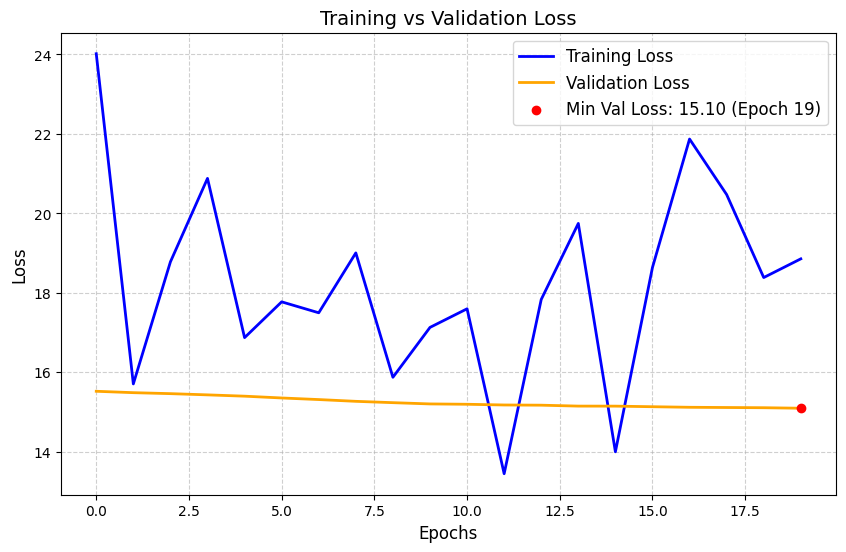

In [9]:
# %%
# Plot the training and validation loss
plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

# Menandai minimum validation loss
min_val_loss = min(history.history['val_loss'])
min_val_epoch = history.history['val_loss'].index(min_val_loss)
plt.scatter(min_val_epoch, min_val_loss, color='red', label=f"Min Val Loss: {min_val_loss:.2f} (Epoch {min_val_epoch})", zorder=5)

# Menambahkan judul dan label
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)

# Menambahkan grid
plt.grid(True, linestyle='--', alpha=0.6)

# Menampilkan grafik
plt.show()



In [10]:
# Generate recommendations for a user based on emotions
def generate_recommendations(user_id, emotion_dominant):
    # Peta deskripsi emosi
    emotion_descriptions = {
        "kecewa": "Kamu merasa kecewa karena harapanmu tidak terwujud.",
        "frustrasi": "Kamu merasa kesal dan tidak tahu bagaimana menghadapinya.",
        "bingung": "Kamu merasa bingung dan tidak tahu harus memilih yang mana.",
        "bahagia": "Kamu merasa penuh kebahagiaan dan kegembiraan.",
        "cemas": "Kamu merasa khawatir tentang masa depan atau hal yang belum pasti.",
        "marah": "Kamu merasa marah dan ingin mengubah keadaan.",
        "kesal": "Kamu merasa kesal dan tidak bisa menahan perasaan tersebut.",
        "sedih": "Kamu merasa tertekan dan kehilangan semangat.",
        "tertarik": "Kamu merasa tertarik dan ingin tahu lebih banyak tentang sesuatu.",
        "optimis": "Kamu merasa percaya diri dan berharap yang terbaik untuk masa depan.",
        "tenang": "Kamu merasa tentram dan tidak terpengaruh oleh gangguan.",
        "gembira": "Kamu merasa senang dan penuh semangat.",
        "puas": "Kamu merasa puas dengan apa yang telah tercapai.",
        "nyaman": "Kamu merasa nyaman dan tidak ada hal yang mengganggu.",
        "bergairah": "Kamu merasa penuh energi dan antusiasme.",
        "aneh": "Kamu merasa ada sesuatu yang aneh atau tidak biasa.",
        "euforis": "Kamu merasa sangat bahagia dan penuh dengan kebahagiaan eksternal.",
        "tertantang": "Kamu merasa tertantang untuk mencapai tujuan yang lebih besar.",
        "penuh harapan": "Kamu merasa memiliki harapan yang kuat untuk masa depan.",
        "terinspirasi": "Kamu merasa termotivasi untuk melakukan sesuatu yang besar.",
        "panik": "Kamu merasa cemas dan kehilangan kendali atas situasi.",
        "rindu": "Kamu merasa kangen dan ingin bertemu dengan seseorang atau sesuatu.",
        "takut": "Kamu merasa ketakutan dan khawatir tentang apa yang akan terjadi.",
        "senyum": "Kamu merasa bahagia hingga tidak bisa menahan senyum.",
        "terharu": "Kamu merasa sangat tersentuh dan emosional.",
        "bersyukur": "Kamu merasa berterima kasih atas apa yang ada dalam hidupmu.",
        "malu": "Kamu merasa malu dan tidak ingin berada dalam perhatian.",
        "tersenyum": "Kamu merasa senang hingga tidak bisa menahan untuk tersenyum.",
        "terkejut": "Kamu merasa terkejut dengan kejadian yang tidak terduga.",
        "gugup": "Kamu merasa cemas dan khawatir tentang apa yang akan terjadi.",
        "gemas": "Kamu merasa gemas dan tidak bisa menahan rasa sayang.",
        "terluka": "Kamu merasa terluka baik fisik maupun emosional, dan butuh waktu untuk sembuh."
    }

    # Filter hanya emosi yang ada di dalam dictionary
    valid_emotions = [emotion.lower() for emotion in emotion_dominant if emotion.lower() in emotion_descriptions]

    # Jika ada emosi yang valid, gabungkan deskripsinya
    if valid_emotions:
        dominant_emotion = valid_emotions[0]  # Ambil emosi pertama dari yang valid
        msg_emotion = emotion_descriptions[dominant_emotion]  # Deskripsi untuk emosi dominan
    else:
        msg_emotion = "Emosi tidak dikenal"

    # Mendapatkan rekomendasi berbasis model NCF
    recommendations = []

    # Convert user_id to numeric
    user_id_num = user_encoder.transform([user_id])[0]
    
    # Predict ratings for all items
    item_ids = np.arange(len(item_encoder.classes_))
    predicted_ratings = model.predict([np.full_like(item_ids, user_id_num), item_ids])

    # Sort items based on predicted ratings
    top_items = item_ids[np.argsort(predicted_ratings.flatten())[-5:]] 
    
    # Set untuk mengecek duplikasi judul
    seen_titles = set()

    # Retrieve recommended book details
    for item_id in top_items:
        item_title = item_encoder.inverse_transform([item_id])[0]
        for entry in data:
            for recommendation in entry['reccomendation']:
                if recommendation["title"] == item_title and item_title not in seen_titles:
                    recommendations.append({
                        "title": recommendation["title"],
                        "image": recommendation["image"],
                        "desc": recommendation["desc"]
                    })
                    seen_titles.add(item_title)  # Tandai bahwa judul ini sudah ditambahkan
                    break

    # Mengembalikan hasil rekomendasi dan pesan emosi
    return {
        "msgEmotion": msg_emotion,
        "reccomendation": recommendations[:5]  # Ambil 3 rekomendasi teratas
    }


In [11]:
# Contoh penggunaan:
user_recommendations = generate_recommendations("1", ["aneh", "Kecewa"])

# Menampilkan hasil dalam format yang mudah dibaca
print("Pesan Emosi:", user_recommendations["msgEmotion"])

# Menampilkan tabel dengan IPython display
display(pd.DataFrame(user_recommendations["reccomendation"])[['title', 'image', 'desc']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Pesan Emosi: Kamu merasa ada sesuatu yang aneh atau tidak biasa.


,title,image,desc
0,Gita Cinta dari SMA,https://example.com/gita_cinta_dari_sma.jpg,Film klasik yang bisa membawa kembali kenangan...
1,Keluarga Cemara,https://example.com/keluarga_cemara.jpg,Film keluarga yang penuh dengan kebahagiaan da...
2,Sebelum Iblis Menjemput,https://example.com/sebelum_iblis_menjemput.jpg,"Film horor yang penuh ketegangan, bisa membant..."
3,Dilan 1991,https://example.com/dilan_1991.jpg,Film yang menggugah perasaan dengan cerita yan...
4,The Raid,https://example.com/the_raid.jpg,"Film aksi yang inspiratif, penuh dengan aksi y..."
